In [1]:
import tensorflow as tf
import pandas            as pd
import tensorflow        as tf  
import numpy             as np
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

from numpy                 import array
from sklearn               import metrics
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models          import Sequential
from tensorflow.keras.layers          import Dense,LSTM,Bidirectional


# 确保结果尽可能重现
from numpy.random   import seed
seed(1)
tf.random.set_seed(1)

# 设置相关参数
n_timestamp  = 40    # 时间戳
n_epochs     = 20    # 训练轮数
# ====================================
#      选择模型：
#            1: 单层 LSTM
#            2: 多层 LSTM
#            3: 双向 LSTM
# ====================================
model_type = 2


In [2]:
# 导入tushare
import tushare as ts
# 初始化pro接口
pro = ts.pro_api('84a7d42ba53be1e345b15650d19116113087ad5440320b4c6b7b6c67')

# 拉取数据
data = pro.daily(**{
    "ts_code": '688333.sh',
    "trade_date": "",
    "start_date": "",
    "end_date": "",
    "offset": "",
    "limit": ""
}, fields=[
    "trade_date",
    "open",
    "close",
    "high",
    "low",
    "vol",
    "ts_code"
])


In [3]:
print(data)
data.to_csv("stock688333.csv")

       ts_code trade_date    open    high     low   close        vol
0    688333.SH   20211014  203.21  205.46  199.00  199.50    2314.23
1    688333.SH   20211013  203.00  204.00  198.00  203.21    2135.11
2    688333.SH   20211012  213.82  213.82  198.08  201.90    2820.59
3    688333.SH   20211011  208.64  216.33  206.34  210.08    3148.10
4    688333.SH   20211008  211.47  211.47  205.00  208.81    2364.72
..         ...        ...     ...     ...     ...     ...        ...
536  688333.SH   20190726   68.00   70.79   66.18   67.34   55146.48
537  688333.SH   20190725   65.46   76.00   65.03   71.02   95340.23
538  688333.SH   20190724   61.21   68.00   61.18   67.99   93735.42
539  688333.SH   20190723   54.50   62.00   54.00   57.40   58753.25
540  688333.SH   20190722   61.00   96.00   43.40   64.33  148263.07

[541 rows x 7 columns]


In [4]:

#data.iloc[0:4813-300,3]
#plt.xlabel("Time")
#plt.ylabel("Price")
#i=data["low"].items()
#i,x=data["trade_date"].items()


for item in data.items():
    print(item[0])
     
#plt.pli ot(x,y)
#plt.show()
#print(data["open"])

ts_code
trade_date
open
high
low
close
vol


In [5]:
data1=pd.DataFrame(data,columns=["trade_date","close"])
#data1=data1.iloc[::-1]
#plt.plot(data1["close"])
ddd=[]
for item in data1.items():
    ddd.append(item)
ind=ddd[0][1].values
da1=ddd[1][1].values
index1=[]
data2=[]
for item in ind:
    index1.append(item)
index1.reverse()
for item in da1:
    data2.append(item)
data2.reverse()
data1={'trade_date':index1,'close':data2}
stockdata=pd.DataFrame(data1)

stockdata.items    

<bound method DataFrame.items of     trade_date   close
0     20190722   64.33
1     20190723   57.40
2     20190724   67.99
3     20190725   71.02
4     20190726   67.34
..         ...     ...
536   20211008  208.81
537   20211011  210.08
538   20211012  201.90
539   20211013  203.21
540   20211014  199.50

[541 rows x 2 columns]>

In [6]:

training_set = stockdata.iloc[0:512, 1:3]
test_set     = stockdata.iloc[537 - 300:, 1:3]
#将数据归一化，范围是0到1
sc  = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled  = sc.transform(test_set) 


In [7]:
# 取前 n_timestamp 天的数据为 X；n_timestamp+1天数据为 Y。
def data_split(sequence, n_timestamp):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp
        
        if end_ix > len(sequence)-1:
            break
            
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

X_train, y_train = data_split(training_set_scaled, n_timestamp)
X_train          = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_test, y_test   = data_split(testing_set_scaled, n_timestamp)
X_test           = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [8]:
#五、构建模型
# 建构 LSTM模型
model_type=3
if model_type == 1:
    # 单层 LSTM
    model = Sequential()
    model.add(LSTM(units=50, activation='relu',
                   input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
if model_type == 2:
    # 多层 LSTM
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', return_sequences=True,
                   input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50, activation='relu'))
    model.add(Dense(1))
if model_type == 3:
    # 双向 LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'),
                            input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))

model.summary()  # 输出模型结构

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100)               20800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
#七、训练模型
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=n_epochs,
                    validation_data=(X_test, y_test),
                    validation_freq=1)  # 测试的epoch间隔数

model.summary()

Epoch 1/20
8/8 [==============================] - 4s 100ms/step - loss: 0.1276 - val_loss: 0.2174
Epoch 2/20
8/8 [==============================] - 0s 42ms/step - loss: 0.0800 - val_loss: 0.1283
Epoch 3/20
8/8 [==============================] - 0s 39ms/step - loss: 0.0435 - val_loss: 0.0394
Epoch 4/20
8/8 [==============================] - 0s 37ms/step - loss: 0.0179 - val_loss: 0.0490
Epoch 5/20
8/8 [==============================] - 0s 37ms/step - loss: 0.0164 - val_loss: 0.0154
Epoch 6/20
8/8 [==============================] - 0s 38ms/step - loss: 0.0128 - val_loss: 0.0158
Epoch 7/20
8/8 [==============================] - 0s 43ms/step - loss: 0.0091 - val_loss: 0.0540
Epoch 8/20
8/8 [==============================] - 0s 40ms/step - loss: 0.0075 - val_loss: 0.0385
Epoch 9/20
8/8 [==============================] - 0s 39ms/step - loss: 0.0073 - val_loss: 0.0538
Epoch 10/20
8/8 [==============================] - 0s 40ms/step - loss: 0.0066 - val_loss: 0.0276
Epoch 11/20
8/8 [===========

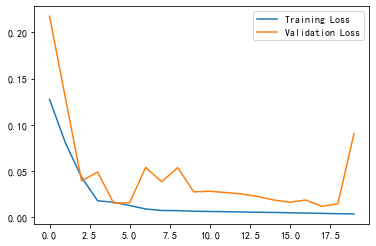

In [10]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [11]:
predicted_stock_price = model.predict(
    X_test)                        # 测试集输入模型进行预测
predicted_stock_price = sc.inverse_transform(
    predicted_stock_price)  # 对预测数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc.inverse_transform(y_test)  # 对真实数据还原---从（0，1）反归一化到原始范围

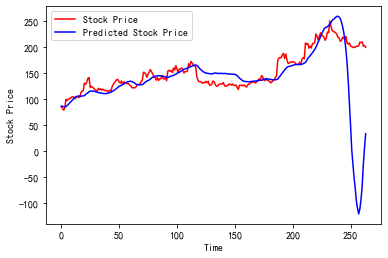

In [12]:
# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
#plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [13]:
MSE = metrics.mean_squared_error(predicted_stock_price, real_stock_price)
RMSE = metrics.mean_squared_error(predicted_stock_price, real_stock_price)**0.5
MAE = metrics.mean_absolute_error(predicted_stock_price, real_stock_price)
R2 = metrics.r2_score(predicted_stock_price, real_stock_price)

print('均方误差: %.5f' % MSE)
print('均方根误差: %.5f' % RMSE)
print('平均绝对误差: %.5f' % MAE)
print('R2: %.5f' % R2)

均方误差: 3826.82294
均方根误差: 61.86132
平均绝对误差: 25.20611
R2: -0.11625
